In [6]:
import tensorflow as tf
import pickle
from tensorflow import keras
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import datetime

def obtener_tiempo(dfr):
    #Esta funcion permite obtener una columna Datetime a partir del agno, dia, hora y minuto de los datos iniciales
    dfr['Day'] = pd.to_datetime(dfr['Day'], format='%j').dt.strftime('%m-%d')
    dfr['Hour'] = dfr['Hour'].astype(str).str.zfill(2)
    dfr['Datetime'] = pd.to_datetime(dfr[['Year','Day', 'Hour', 'Minute']]
                   .astype(str).apply(' '.join, 1), format='%Y %m-%d %H %M') 
    return dfr

def sustituir(dfr):
    #Sustitucion de los valores 9999... por NaN (sabemos que la fila 2 son todo valores nulos para cada variable)
    valores_null = dfr.iloc[2, 4:]
    for i in range(len(valores_null)):
        dfr.iloc[:,i+4] = dfr.iloc[:,i+4].replace(valores_null[i], np.nan)
    return dfr

def imputar_por_interpolacion(dfr):
    #Sustituye los valores NaN por valores aproximados mediante el metodo de interpolacion
    dfr = dfr.interpolate(method='linear', limit_direction='forward')
    return dfr

def imputar_por_KNND(dfr):
    #Este metodo es para imputar las filas que no se hayan podido imputar con interpolacion (primera fila)
    imputer = KNNImputer(n_neighbors=3, weights = 'distance')
    dfr[:] = imputer.fit_transform(dfr)
    return dfr

def normalizar_datos(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores normalizados
    x = dfr.values #returns a numpy array
    standard_scaler = preprocessing.StandardScaler()
    dfr[:] = standard_scaler.fit_transform(x)
    #dfr = pd.DataFrame(x_scaled)
    return dfr

def desnormalizar_datos(dfr):
    #Dado un DataFrame, devuelve el DataFrame con valores desnormalizados
    x = dfr.values
    min_max_scaler = preprocessing.MinMaxScaler()
    dfr[:] = min_max_scaler.inverse_transform(x)
    return dfr

def eliminar_gaps(dfr, n):
    #Eliminacion de filas donde alguna columna tiene N NaNs consecutivos
    for columna in range(dfr.shape[1]):
        mask = dfr.iloc[:,columna].notna()
        a = mask.ne(mask.shift()).cumsum()
        dfr = dfr[(a.groupby(a).transform('size') < n) | mask]
    return dfr

def NaN_consecutivos(dfr):
    #Obtencion del numero maximo de NaN consecutivos segun columna
    nans_consecutivos = []
    for columna in range(df.shape[1]):
        nan_columna = max(df.iloc[:,columna].isnull().astype(int).groupby(df.iloc[:,columna].notnull().astype(int).cumsum()).sum())
        nans_consecutivos.append(nan_columna)

    df_nans = pd.DataFrame(columns = ['Variable','Numero de nans consecutivos'])
    df_nans.iloc[:,0] = df.columns
    df_nans.iloc[:,1] = nans_consecutivos
    return df_nans

In [2]:
#Leemos los datos
df = pd.read_csv('datos.csv', header=0)

In [3]:
#=====================================================IMPUTACION DE DATOS=======================================================
#Cambiamos los 9999... por NaN para imputar de una manera mas comoda
df = sustituir(df)

In [4]:
#Imputamos todos los valores NaN restantes por interpolacion a excepcion de la primera fila (no se tiene un valor anterior)
df = imputar_por_interpolacion(df)
df

,Year,Day,Hour,Minute,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
0,1995,1,0,0,1.37,0.130,1.17,-0.670,NaN,NaN,NaN
1,1995,1,0,5,1.26,0.090,1.12,-0.500,311.40,18.460,17347.0
2,1995,1,0,10,1.46,0.037,1.30,-0.586,311.56,18.348,17510.6
3,1995,1,0,15,1.66,-0.016,1.48,-0.672,311.72,18.236,17674.2
4,1995,1,0,20,1.86,-0.069,1.66,-0.758,311.88,18.124,17837.8
...,...,...,...,...,...,...,...,...,...,...,...
2749243,2021,49,23,35,2.87,2.130,0.03,-1.860,364.10,4.670,58514.0
2749244,2021,49,23,40,2.92,2.210,0.07,-1.880,364.90,4.400,62883.0
2749245,2021,49,23,45,2.90,2.450,0.05,-1.540,364.10,4.650,58624.0
2749246,2021,49,23,50,2.92,2.380,0.13,-1.660,363.70,4.810,67353.0


In [5]:
#Imputamos la primera fila por KNND, pasamos 4 filas(0/1/2/3) porque se basa en los 3 primeros vecinos (3 vecinos +1 imputa)
imputar_por_KNND(df.iloc[:3, :])
df

<ipython-input-1-362bf8c385d4>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfr[:] = imputer.fit_transform(dfr)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Year,Day,Hour,Minute,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
0,1995,1,0,0,1.37,0.130,1.17,-0.670,311.453358,18.422649,17401.558702
1,1995,1,0,5,1.26,0.090,1.12,-0.500,311.400000,18.460000,17347.000000
2,1995,1,0,10,1.46,0.037,1.30,-0.586,311.560000,18.348000,17510.600000
3,1995,1,0,15,1.66,-0.016,1.48,-0.672,311.720000,18.236000,17674.200000
4,1995,1,0,20,1.86,-0.069,1.66,-0.758,311.880000,18.124000,17837.800000
...,...,...,...,...,...,...,...,...,...,...,...
2749243,2021,49,23,35,2.87,2.130,0.03,-1.860,364.100000,4.670000,58514.000000
2749244,2021,49,23,40,2.92,2.210,0.07,-1.880,364.900000,4.400000,62883.000000
2749245,2021,49,23,45,2.90,2.450,0.05,-1.540,364.100000,4.650000,58624.000000
2749246,2021,49,23,50,2.92,2.380,0.13,-1.660,363.700000,4.810000,67353.000000


In [6]:
#Cambiamos las columnas Year Day Hour Minute por Datetime
df = obtener_tiempo(df)
df = df.drop(['Year', 'Day', 'Hour', 'Minute'], axis = 1)
df = df.set_index('Datetime')

In [7]:
#====================================PREPROCESADO DE DATOS========================================================
"""
Normalizar los datos permite al modelo aprender de una manera más efectiva, ya que los valores de
todas las columnas estaran comprendidas entre 0 y 1. Si tuviesemos algun valor muy grande en alguna columna
por ejemplo, un rango comprendido entre 500 y 1000, y el resto de columnas tuviese valores entre 0 y 1
Podria ocurrir que el modelo diese mayor peso a ese valor grande cuando realmente no es tan significante
para realizar una buena prediccion, impidiendo la optimización del modelo
"""
df = normalizar_datos(df)
df

,IMF(nT),Bx GSM(nT),By GSM(nT),Bz GSM(nT),Flow Speed(km/s),Proton Density(n/cc),Proton Temperature(K)
Datetime,,,,,,,
1995-01-01 00:00:00,-1.424353,0.032687,0.291615,-0.189644,-1.146234,2.347966,-0.802707
1995-01-01 00:05:00,-1.460589,0.021451,0.278938,-0.138110,-1.146766,2.355286,-0.803304
1995-01-01 00:10:00,-1.394705,0.006564,0.324574,-0.164180,-1.145172,2.333336,-0.801513
1995-01-01 00:15:00,-1.328821,-0.008324,0.370210,-0.190250,-1.143577,2.311387,-0.799722
1995-01-01 00:20:00,-1.262937,-0.023212,0.415845,-0.216320,-1.141983,2.289437,-0.797931
...,...,...,...,...,...,...,...
2021-02-18 23:35:00,-0.930224,0.594484,0.002589,-0.550381,-0.621617,-0.347237,-0.352641
2021-02-18 23:40:00,-0.913753,0.616956,0.012730,-0.556443,-0.613645,-0.400151,-0.304812
2021-02-18 23:45:00,-0.920341,0.684372,0.007660,-0.453376,-0.621617,-0.351156,-0.351436


In [8]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    #dataset = df con todos los datos
    #target  = la columna del df que queremos predecir (la variable)
    #start_index = pos de la primera fila del dataset
    #end_index = pos de la ultima fila del dataset
    #end_index - start_index = Conjunto de filas a traves de las cuales vamos a obtener las ventanas de entrada y de salida
    #history_size = numero de filas en el pasado que vamos a usar para predecir el futuro, en nuestro caso 60
    #target_size = numero de filas que vamos a predecir para la variable target, en nuestro caso 4
    #step = determina el nivel de solapamiento es decir, si de las 60 primeras filas queremos usar todas ellas [0,1 ...,59]
    #O bien si queremos usar solo la mitad = [0, 2, 4 ,6 ..., 58]
    #En nuestro caso vamos a empezar con solapamiento maximo
    #single_step es por si quisieramos predecir unicamente una unica fila de target.
    
    
    data   = [] #Ventanas temporales con datos de entrenamiento (60)
    labels = [] #Ventanas temporales con la variable objetivo   (6)

    #               data                  labels
    #Ejemplo --> [0, 1, ..., 59] --> [60,61, ...,65]
    
    start_index = start_index + history_size #60
    if end_index is None:
        end_index = len(dataset) - target_size

    for fila in range(start_index, end_index):
        indices = range(fila-history_size, fila, step)
        data.append(dataset[indices])

        #if single_step:
        #    labels.append(target[fila+target_size])
        #else:
        labels.append(target[fila:fila+target_size])

    return np.array(data), np.array(labels)

In [9]:
#===================================Parametros para obtener train_dataset y val_dataset====================================
TRAIN_SPLIT   = int(0.8 * int(df.shape[0]))
STEP          = 1
past_history  = 60
future_target = 6
#BUFFER_SIZE   = 10000

#===================================PARAMETROS DE ENTRENAMIENTO====================================
LEARNING_RATE = 0.001       #Learning rate es la tasa de aprendizaje (mirar word para mas detalle)
EPOCHS        = 20          #Determina el numero de iteraciones que ser realizan sobre los datos de entrenamiento
PATIENCE      = 5
#EVALUATION_INTERVAL = 200
BATCH_SIZE    = 256
DROPOUT_LSTM  = 0.15

In [11]:
#Creacion de datasets de entrenamiento y validacion
dataset = df.values

x_train, y_train = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val, y_val = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [12]:
print (x_train.shape,
       y_train.shape,
       'Single window of past history : {}'.format(x_train[0].shape),
       'Target temperature to predict : {}'.format(y_train[0].shape),
       sep='\n')

(2199338, 60, 7)
(2199338, 6)
Single window of past history : (60, 7)
Target temperature to predict : (6,)


In [13]:
"""
.cache() # almacena el conjunto de datos en memoria (evita tener que volver a aplicar las transformaciones de preprocesamiento a la entrada)
.shuffle(BUFFER_SIZE) # baraja las muestras para tener siempre un orden aleatorio de las muestras alimentadas a la red
.batch(BATCH_SIZE) # agrupa las muestras en trozos de tamaño BATCH_SIZE (excepto el último, que puede ser menor)
.repeat()) # repetir para siempre, lo que significa que el conjunto de datos seguirá produciendo lotes y nunca terminará de quedarse sin datos.
"""
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_data = train_data.cache().batch(BATCH_SIZE)
val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#val_data = val_data.batch(BATCH_SIZE).repeat()
val_data = val_data.batch(BATCH_SIZE)

In [14]:
def create_time_steps(length):
    return list(range(-length, 0))

In [15]:
def multi_step_plot(history, true_future, prediction, style='linea'):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    
    if(style == 'linea'):
        plt.plot(num_in, np.array(history[:, 1]), label='History')
        #plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
        plt.plot(np.arange(num_out)/STEP, np.array(true_future), label='True Future', linestyle = ':', color = 'blue')
        if prediction.any():
            #plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
            plt.plot(np.arange(num_out)/STEP, np.array(prediction), label='Predicted Future', linestyle = ':', color = 'red')
    else:
        plt.plot(num_in, np.array(history[:, 1]), label='History')
        plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo', label='True Future')
        if prediction.any():
            plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [16]:
x_train.shape[-2:]

(60, 7)

In [17]:
#================================Cargar modelo==============================================
#1-Definimos la estructura del modelo (tiene que ser la misma)
model = keras.Sequential(name="base_architecture")
model.add(keras.layers.Input(shape=(x_train.shape[-2:]), name="entrada"))
model.add(keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', name="capa_convolucional"))
model.add(keras.layers.MaxPooling1D(pool_size = 2, name="filtro_MaxPooling"))
model.add(keras.layers.Flatten(name="filtro_flatten"))
model.add(keras.layers.RepeatVector(6, name="filtro_repetir_entrada_X6"))
model.add(keras.layers.LSTM(200, return_sequences=True, name="capa_LSTM", dropout=DROPOUT_LSTM))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(1, name="salida")))
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.01), loss="mse")
#2-Cargamos los pesos del modelo
model.load_weights('modelo_iteracion3.h5')
model.summary()

Model: "base_architecture"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
capa_convolucional (Conv1D)  (None, 60, 64)            1408      
_________________________________________________________________
filtro_MaxPooling (MaxPoolin (None, 30, 64)            0         
_________________________________________________________________
filtro_flatten (Flatten)     (None, 1920)              0         
_________________________________________________________________
filtro_repetir_entrada_X6 (R (None, 6, 1920)           0         
_________________________________________________________________
capa_LSTM (LSTM)             (None, 6, 200)            1696800   
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 1)              201       
Total params: 1,698,409
Trainable params: 1,698,409
Non-trainable params: 0
_______________________________________

In [7]:
#Cargamos el objeto history para ver las curvas de perdida
import pickle
history = pickle.load(open('history_modelo_complejo', "rb"))
history

{'loss': [0.525757372379303,
  0.14754880964756012,
  0.14709246158599854,
  0.1715317666530609,
  0.21617117524147034,
  0.19382651150226593,
  0.2867566645145416,
  0.22906999289989471,
  0.2226349115371704,
  0.21880468726158142,
  0.20853319764137268,
  0.3928353488445282,
  0.20313385128974915,
  0.10975642502307892,
  0.10241075605154037,
  0.0843232050538063,
  0.06974034011363983,
  0.061203405261039734,
  0.08547522127628326,
  0.11981882154941559],
 'mae': [0.41727373003959656,
  0.22226911783218384,
  0.21292521059513092,
  0.2280258983373642,
  0.2522211968898773,
  0.24822589755058289,
  0.25748780369758606,
  0.2413320541381836,
  0.2481193244457245,
  0.2812180519104004,
  0.26207810640335083,
  0.2459614872932434,
  0.22999349236488342,
  0.19651541113853455,
  0.18788325786590576,
  0.18216203153133392,
  0.16061970591545105,
  0.1510540097951889,
  0.17122134566307068,
  0.19167634844779968],
 'mse': [0.5257572531700134,
  0.1475488245487213,
  0.14709250628948212,
  

In [8]:
def plot_train_history(history, title):
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

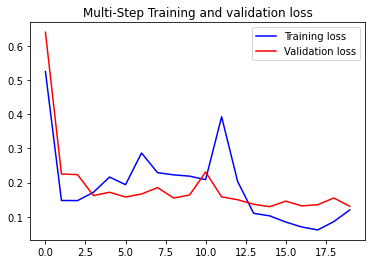

In [9]:
plot_train_history(history, 'Multi-Step Training and validation loss')

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [ ]:
for x, y in val_data.take(4):
    multi_step_plot(x[0], y[0], model.predict(x)[0], '')